In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error

import time
import pandas as pd
import seaborn as sns

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psutil
def memoria_libre():
    return 100-psutil.virtual_memory().percent
memoria_libre()

11.5

In [3]:
psutil.swap_memory().percent

5.3

Model parameters

In [4]:
d = 2
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 2
theta_2 = 2.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [5]:
ns = [
    # x2
    1_000,
    3_000, 
    5_000,
    7_500,
    10_000,
    12_500
]

n_test = 100

num_replications = 10

aux = [] # METHOD, n, N, m, TIME, RMSE

In [ ]:
for n in ns:
    for _ in range(num_replications):
        X_2 = gen_observation_points(d, n, sup)
        X_1 = np.concatenate([gen_observation_points(d, n_test, sup), X_2])
        
        sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
        Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
        Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
        
        X_test, Y_test = X_1[:n_test], Y_1[:n_test]
        X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
        
        if memoria_libre()>10 and psutil.swap_memory().percent<10:
            del sigma
            # CO KRIGING
            start_time = time.time()
            sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
            Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)        
            end_time = time.time()
            aux.append(['coK', n, n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])
        else:
            aux.append(['coK', n, n, 1, np.nan, np.nan])

        del sigma
    
        # NcoK KM
        m = int(np.sqrt(n)/5)
        A_1, A_2 = gen_As(X_1, X_2, m)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK', n, n//m, m, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        del NcoK

In [11]:
aux = pd.DataFrame(aux, columns=['METHOD', 'n', 'N', 'm', 'TIME', 'RMSE'])
aux

,METHOD,n,N,m,TIME,RMSE
0,coK,1000,1000,1,0.333759,0.393363
1,NcoK,1000,166,6,7.166249,0.396255
2,coK,1000,1000,1,0.602017,0.408553
3,NcoK,1000,166,6,6.077562,0.424203
4,coK,1000,1000,1,0.275128,0.417201
...,...,...,...,...,...,...
115,NcoK,12500,568,22,375.241459,0.223571
116,coK,12500,12500,1,NaN,NaN
117,NcoK,12500,568,22,344.242949,0.231861
118,coK,12500,12500,1,NaN,NaN


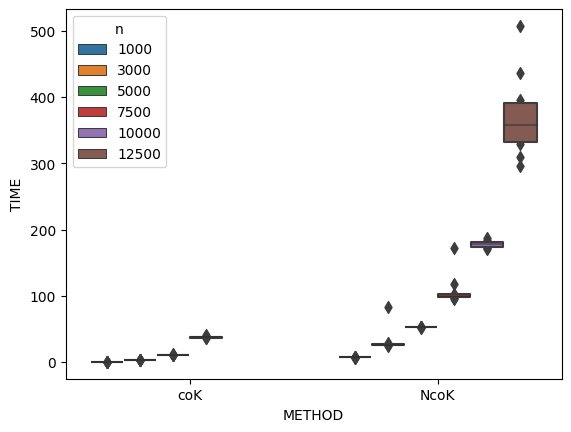

In [12]:
sns.boxenplot(data=aux, x='METHOD', y='TIME', hue='n');

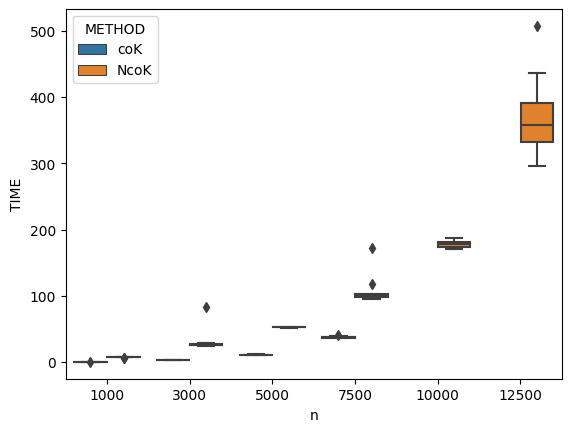

In [13]:
sns.boxplot(data=aux, x='n', y='TIME', hue='METHOD');

In [14]:
aux[aux['TIME'].isna()]

,METHOD,n,N,m,TIME,RMSE
60,coK,7500,7500,1,NaN,NaN
72,coK,7500,7500,1,NaN,NaN
74,coK,7500,7500,1,NaN,NaN
80,coK,10000,10000,1,NaN,NaN
82,coK,10000,10000,1,NaN,NaN
84,coK,10000,10000,1,NaN,NaN
86,coK,10000,10000,1,NaN,NaN
88,coK,10000,10000,1,NaN,NaN
90,coK,10000,10000,1,NaN,NaN
92,coK,10000,10000,1,NaN,NaN


In [15]:
aux.to_csv('results_times.csv', index=False, sep=';')

In [16]:
aux.groupby(['METHOD', 'n'], as_index=False)['TIME'].mean().sort_values(['n', 'METHOD'], ascending=[True, False], ignore_index=True)

,METHOD,n,TIME
0,coK,1000,0.336572
1,NcoK,1000,7.183673
2,coK,3000,3.151923
3,NcoK,3000,31.928044
4,coK,5000,11.126266
5,NcoK,5000,52.770305
6,coK,7500,37.689695
7,NcoK,7500,108.190148
8,coK,10000,NaN
9,NcoK,10000,178.006887
